## Goal

This module will dive into human-in-the-loop, which builds on memory and allows users to interact directly with graphs in various ways.

### Learning Steps:
- `Breakpoints`
- `Dynamic Breakpoints`

#### imports

In [65]:
from typing import Annotated, TypedDict
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, RemoveMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver

from langgraph.graph import START, END, StateGraph, MessageGraph, MessagesState, add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.errors import NodeInterrupt

from IPython.display import display, Image

### tool functions

In [2]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b


In [3]:
tools = [multiply, add, divide]

In [4]:
llm = ChatOpenAI(model="gpt-4o")

In [5]:
llm_with_tools = llm.bind_tools(tools)

In [14]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [15]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()

'''
Pause execution right before running the node(s) named 'tools'.
This is typically used in agentic or tool-using workflows — where the LLM decides what tool to call, and you (the developer) 
want a chance to inspect or approve the action before continuing.
'''
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

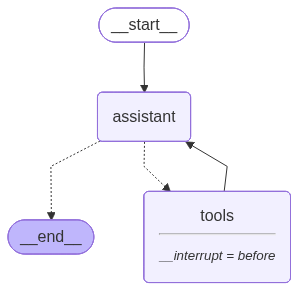

In [16]:
display(Image(graph.get_graph().draw_mermaid_png()))

#### Check the result

In [17]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Xek81SrdP2TYFB12lEEF3UJe)
 Call ID: call_Xek81SrdP2TYFB12lEEF3UJe
  Args:
    a: 2
    b: 3


In [18]:
state = graph.get_state(thread)
state.next

('tools',)

In [19]:
'''
For clarity, LangGraph will re-emit the current state, which contains the AIMessage with tool call.
And then it will proceed to execute the following steps in the graph, which start with the tool node.
We see that the tool node is run with this tool call, and it's passed back to the chat model for our final answer.
'''

for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_Xek81SrdP2TYFB12lEEF3UJe)
 Call ID: call_Xek81SrdP2TYFB12lEEF3UJe
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


#### Lets bring the Human-in-the-Loop - All together

In [20]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_QdGDIxmJyNBFLHC6vLDgRH3C)
 Call ID: call_QdGDIxmJyNBFLHC6vLDgRH3C
  Args:
    a: 2
    b: 3


Do you want to call the tool? (yes/no):  yes


================================== Ai Message ==================================
Tool Calls:
  multiply (call_QdGDIxmJyNBFLHC6vLDgRH3C)
 Call ID: call_QdGDIxmJyNBFLHC6vLDgRH3C
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


#### Get state history

In [22]:
all_states = [s for s in graph.get_state_history(thread)]

In [24]:
len(all_states)

5

In [28]:
to_replay = all_states[-2]

In [30]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='c3bb4072-3522-4a16-a27d-cdec0636d3a1')]}, next=('assistant',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ab270-9985-6a45-8000-d324079f836f'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-17T07:01:00.153914+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0ab270-9981-6e99-bfff-afcd5435021b'}}, tasks=(PregelTask(id='b6270bec-1e91-f7d6-1511-7369b4e8d930', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_QdGDIxmJyNBFLHC6vLDgRH3C', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 

In [29]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='c3bb4072-3522-4a16-a27d-cdec0636d3a1')]}

In [34]:
to_replay.metadata

{'source': 'loop', 'step': 0, 'parents': {}}

In [31]:
to_replay.next

('assistant',)

In [32]:
to_replay.config

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ab270-9985-6a45-8000-d324079f836f'}}

In [33]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_T393ftrK7j9SnAEqjgDqixmT)
 Call ID: call_T393ftrK7j9SnAEqjgDqixmT
  Args:
    a: 2
    b: 3


#### Real life example

In [39]:
import operator

from langchain_community.document_loaders import WikipediaLoader
from langchain_tavily import TavilySearch

#### Declaring state
- Either use `operator.add` or `add_messages`

In [37]:
# class State(TypedDict):
#     question: str
#     answer: str
#     context: Annotated[list, operator.add]

In [66]:
# using add_messages
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, add_messages]

In [67]:
def search_web(state):
    
    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearch(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs["results"]
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'], load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def generate_answer(state):
    
    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)    
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}

#### Building Graph

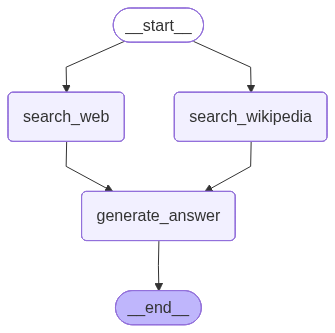

In [68]:
# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [69]:
result = graph.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
result['answer'].content

"Nvidia's Q2 2024 earnings were strong, with the company reporting $46.7 billion in revenue. This surpassed their previous sales record of $44.1 billion achieved in the first quarter of 2024 and also exceeded economist forecasts of $46.05 billion. While Nvidia's earnings per share and revenue growth have moderated compared to the substantial growth during the AI surge, the company's revenue for the quarter still set a new record."